# Project: Providing data-driven suggestions for TikTok

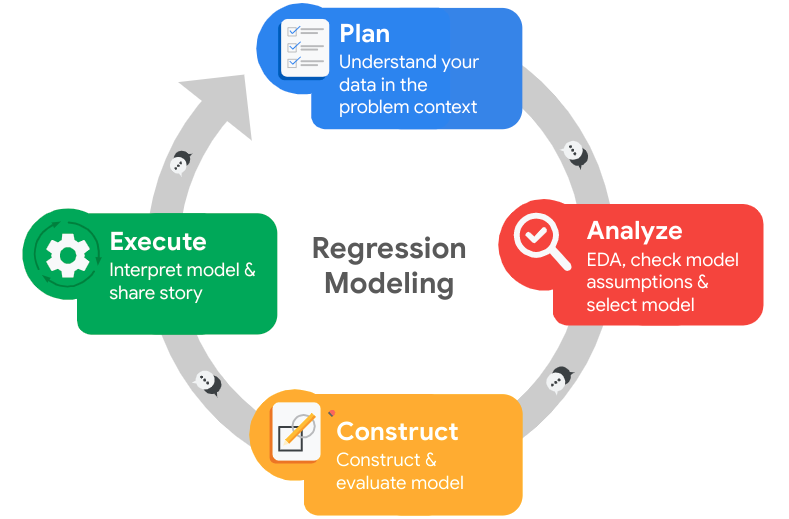

## **Pace: Plan**


### Understand the business scenario and problem

TikTok users have the ability to report videos and comments that contain user claims. These reports identify content that needs to be reviewed by moderators. This process generates a large number of user reports that are difficult to address quickly. 

TikTok is working on the development of a predictive model that can determine whether a video contains a claim or offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

**The goal** in this project is the development of a predictive model that can determine whether a video contains a claim or offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [4]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")
data.head(20)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


##  Data Exploration (Initial EDA and data cleaning)

- Understand the variables
- Clean the dataset (missing data, redundant data, outliers) 


In [5]:
data.info() # Getting summary info.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
data.describe(include='all')

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,19084,1.938200e+04,19382.000000,19084,19382,19382,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
unique,NaN,2,NaN,NaN,19012,2,3,NaN,NaN,NaN,NaN,NaN
top,NaN,claim,NaN,NaN,a friend read in the media a claim that badmi...,not verified,active,NaN,NaN,NaN,NaN,NaN
freq,NaN,9608,NaN,NaN,2,18142,15663,NaN,NaN,NaN,NaN,NaN
mean,9691.500000,NaN,5.627454e+09,32.421732,NaN,NaN,NaN,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,NaN,2.536440e+09,16.229967,NaN,NaN,NaN,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,NaN,1.234959e+09,5.000000,NaN,NaN,NaN,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,NaN,3.430417e+09,18.000000,NaN,NaN,NaN,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,NaN,5.618664e+09,32.000000,NaN,NaN,NaN,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,NaN,7.843960e+09,47.000000,NaN,NaN,NaN,504327.000000,125020.000000,18222.000000,1156.250000,292.000000


In [7]:
data.isna().any()

#                           False
claim_status                 True
video_id                    False
video_duration_sec          False
video_transcription_text     True
verified_status             False
author_ban_status           False
video_view_count             True
video_like_count             True
video_share_count            True
video_download_count         True
video_comment_count          True
dtype: bool

In [8]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

# pAce: Analyze Stage
- Perform EDA (analyze relationships between variables) 

In [9]:
# the different values for claim status and how many of each are in the data
data['claim_status'].value_counts()

claim      9608
opinion    9476
Name: claim_status, dtype: int64

In [10]:
# the average view count of videos with "claim" status?

claims = data[data['claim_status'] == 'claim']
print('Mean view count claims:', claims['video_view_count'].mean())
print('Median view count claims:', claims['video_view_count'].median())

Mean view count claims: 501029.4527477102
Median view count claims: 501555.0


In [11]:
# the average view count of videos with "opinion" status?

opinions = data[data['claim_status'] == 'opinion']
print('Mean view count opinions:', opinions['video_view_count'].mean())
print('Median view count opinions:', opinions['video_view_count'].median())

Mean view count opinions: 4956.43224989447
Median view count opinions: 4953.0


**Note:** The mean and the median within each claim category are close to one another, but there is a vast discrepancy between view counts for videos labeled as claims and videos labeled as opinions.


In [12]:
# counts for each group combination of claim status and author ban status

data.groupby(['claim_status', 'author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

**Note:** There are many more claim videos with banned authors than there are opinion videos with banned authors. This could mean a number of things, including the possibilities that:
* Claim videos are more strictly policed than opinion videos
* Authors must comply with a stricter set of rules if they post a claim than if they post an opinion

Also, it should be noted that there's no way of knowing if claim videos are inherently more likely than opinion videos to result in author bans, or if authors who post claim videos are more likely to post videos that violate terms of service.


In [13]:
data.groupby(['author_ban_status']).agg(
    {'video_view_count': ['mean', 'median'],
     'video_like_count': ['mean', 'median'],
     'video_share_count': ['mean', 'median']})

video_view_count           video_like_count            \
                              mean    median             mean    median   
author_ban_status                                                         
active               215927.039524    8616.0     71036.533836    2222.0   
banned               445845.439144  448201.0    153017.236697  105573.0   
under review         392204.836399  365245.5    128718.050339   71204.5   

                  video_share_count           
                               mean   median  
author_ban_status                             
active                 14111.466164    437.0  
banned                 29998.942508  14468.0  
under review           25774.696999   9444.0

In [15]:
# the median video share count of each author ban status?

data.groupby(['author_ban_status']).median(numeric_only=True)[
    ['video_share_count']]

,video_share_count
author_ban_status,
active,437.0
banned,14468.0
under review,9444.0


**Note:** Banned authors have a median share count that's 33 times the median share count of active authors! We can explore this in more depth.

In [16]:
data.groupby(['author_ban_status']).agg(
    {'video_view_count': ['count', 'mean', 'median'],
     'video_like_count': ['count', 'mean', 'median'],
     'video_share_count': ['count', 'mean', 'median']
     })

video_view_count                          video_like_count  \
                             count           mean    median            count   
author_ban_status                                                              
active                       15383  215927.039524    8616.0            15383   
banned                        1635  445845.439144  448201.0             1635   
under review                  2066  392204.836399  365245.5             2066   

                                           video_share_count                \
                            mean    median             count          mean   
author_ban_status                                                            
active              71036.533836    2222.0             15383  14111.466164   
banned             153017.236697  105573.0              1635  29998.942508   
under review       128718.050339   71204.5              2066  25774.696999   

                            
                    median  
author_ban_status           
active               437.0  
banned             14468.0  
under review        9444.0

**Note:** A few observations stand out:
* Banned authors and those under review get far more views, likes, and shares than active authors.
* In most groups, the mean is much greater than the median, which indicates that there are some videos with very high engagement counts 

In [17]:
# Creating a likes_per_view column
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']

# Creating a comments_per_view column
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']

# Creating a shares_per_view column
data['shares_per_view'] = data['video_share_count'] / data['video_view_count']

In [18]:
data.groupby(['claim_status', 'author_ban_status']).agg(
    {'likes_per_view': ['count', 'mean', 'median'],
     'comments_per_view': ['count', 'mean', 'median'],
     'shares_per_view': ['count', 'mean', 'median']})

likes_per_view                      \
                                        count      mean    median   
claim_status author_ban_status                                      
claim        active                      6566  0.329542  0.326538   
             banned                      1439  0.345071  0.358909   
             under review                1603  0.327997  0.320867   
opinion      active                      8817  0.219744  0.218330   
             banned                       196  0.206868  0.198483   
             under review                 463  0.226394  0.228051   

                               comments_per_view                      \
                                           count      mean    median   
claim_status author_ban_status                                         
claim        active                         6566  0.001393  0.000776   
             banned                         1439  0.001377  0.000746   
             under review                   1603  0.001367  0.000789   
opinion      active                         8817  0.000517  0.000252   
             banned                          196  0.000434  0.000193   
             under review                    463  0.000536  0.000293   

                               shares_per_view                      
                                         count      mean    median  
claim_status author_ban_status                                      
claim        active                       6566  0.065456  0.049279  
             banned                       1439  0.067893  0.051606  
             under review                 1603  0.065733  0.049967  
opinion      active                       8817  0.043729  0.032405  
             banned                        196  0.040531  0.030728  
             under review                  463  0.044472  0.035027

**Note:** Videos by banned authors and those under review tend to get far more views, likes, and shares than videos by non-banned authors. However, *when a video does get viewed*, its engagement rate is less related to author ban status and more related to its claim status.


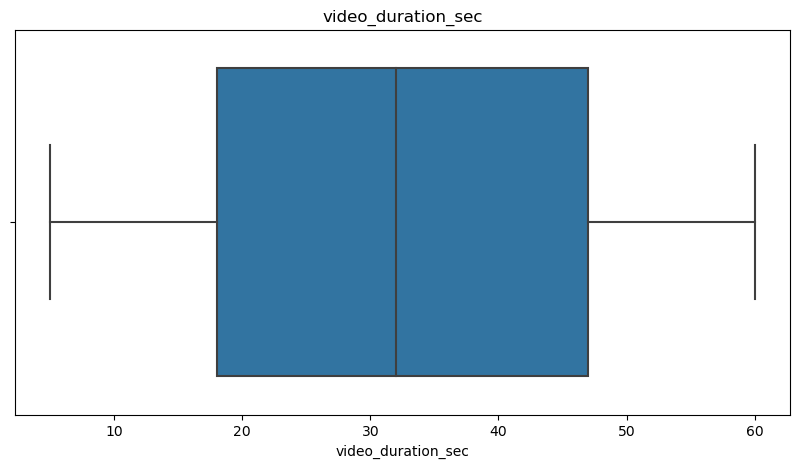

In [19]:
# a boxplot to visualize distribution of `video_duration_sec`
plt.figure(figsize=(10,5))
plt.title('video_duration_sec')
sns.boxplot(x=data['video_duration_sec']);

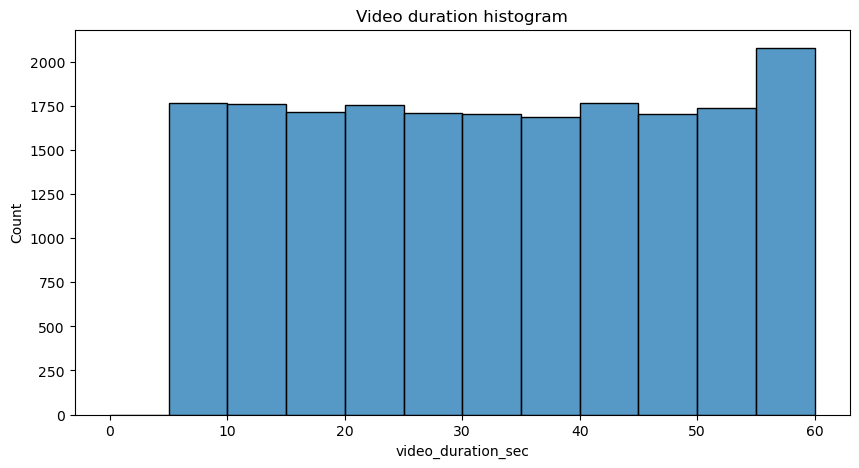

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(data['video_duration_sec'], bins=range(0,61,5))
plt.title('Video duration histogram');


**Note:** All videos are 5-60 seconds in length, and the distribution is uniform.

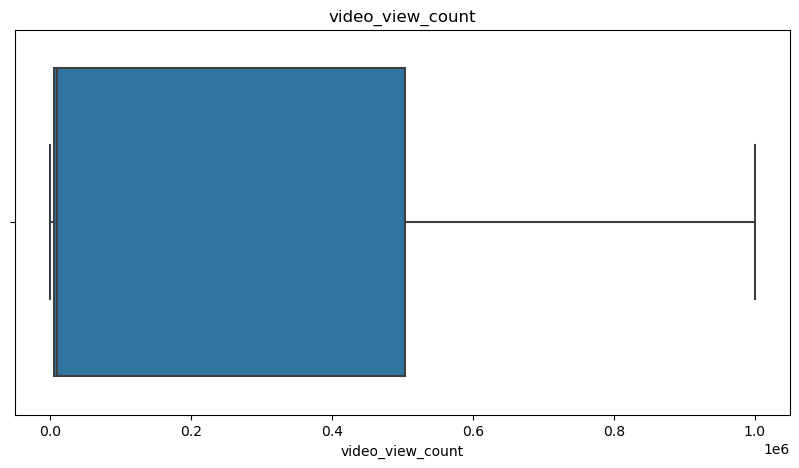

In [23]:
# a boxplot to visualize distribution of `video_view_count`
plt.figure(figsize=(10, 5))
plt.title('video_view_count')
sns.boxplot(x=data['video_view_count']);

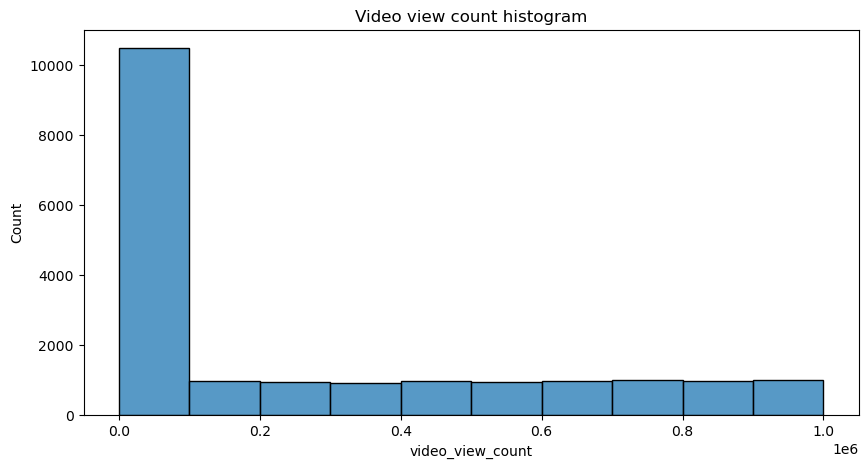

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(data['video_view_count'], bins=range(0,(10**6+1),10**5))
plt.title('Video view count histogram');

**Note:** This variable has a very uneven distribution, with more than half the videos receiving fewer than 100,000 views. Distribution of view counts > 100,000 views is uniform.

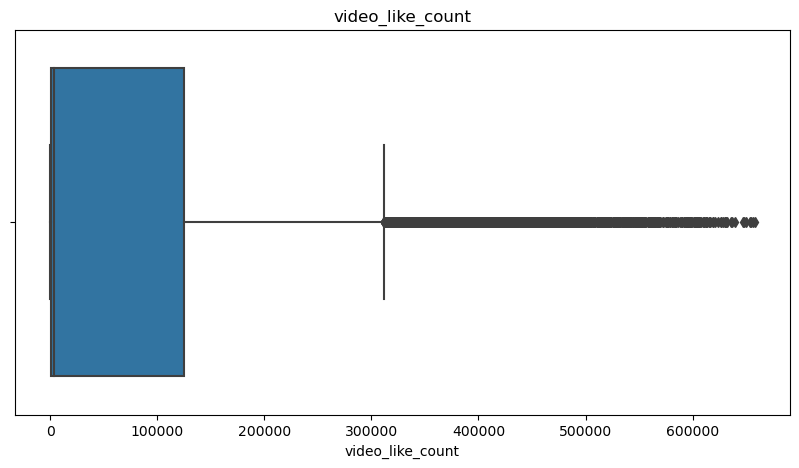

In [25]:
# a boxplot to visualize distribution of `video_like_count`
plt.figure(figsize=(10,5))
plt.title('video_like_count')
sns.boxplot(x=data['video_like_count']);

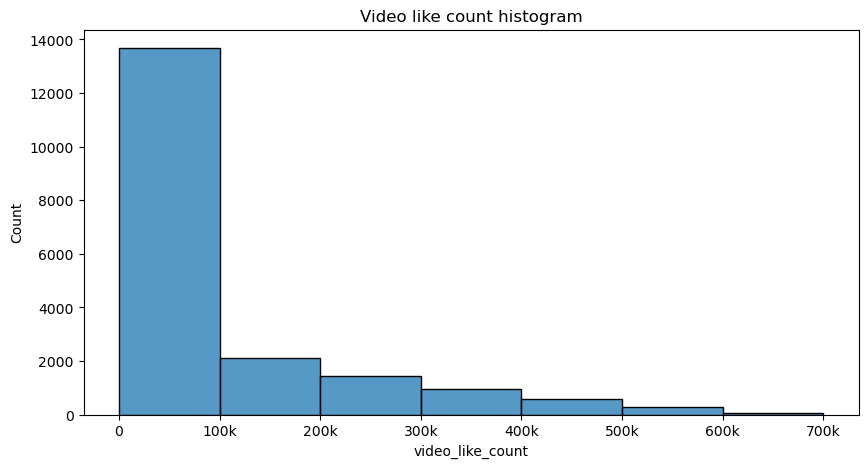

In [26]:
plt.figure(figsize=(10,5))
ax = sns.histplot(data['video_like_count'], bins=range(0,(7*10**5+1),10**5))
labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]
ax.set_xticks(range(0,7*10**5+1,10**5), labels=labels)
plt.title('Video like count histogram');

**Note:** Similar to view count, there are far more videos with < 100,000 likes than there are videos with more. However, in this case, there is more of a taper, as the data skews right, with many videos at the upper extremity of like count.


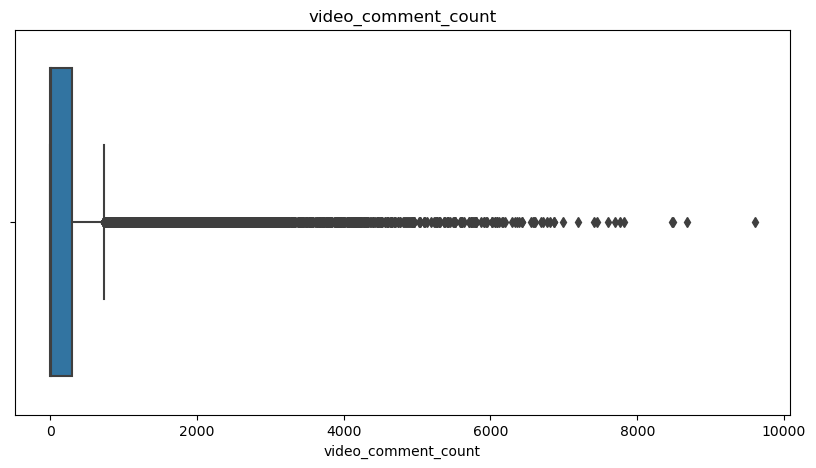

In [27]:
# a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(10,5))
plt.title('video_comment_count')
sns.boxplot(x=data['video_comment_count']);

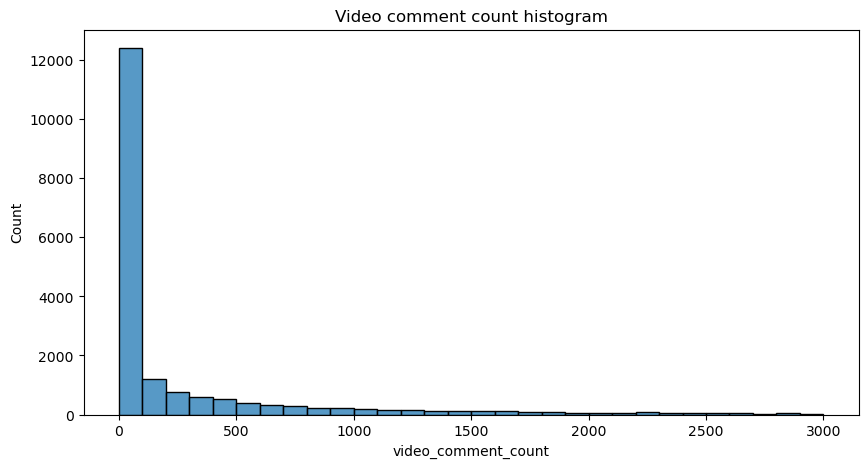

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(data['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

**Note:** Again, the vast majority of videos are grouped at the bottom of the range of values for video comment count. Most videos have fewer than 100 comments. The distribution is very right-skewed.

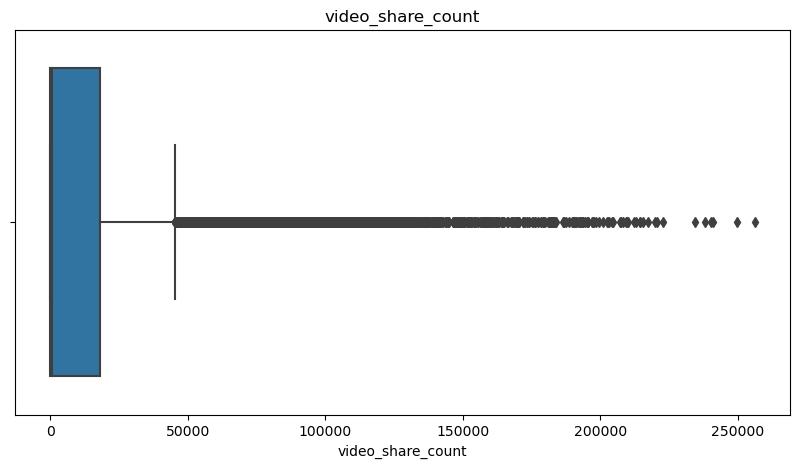

In [30]:
# a boxplot to visualize distribution of `video_share_count`
plt.figure(figsize=(10,5))
plt.title('video_share_count')
sns.boxplot(x=data['video_share_count']);

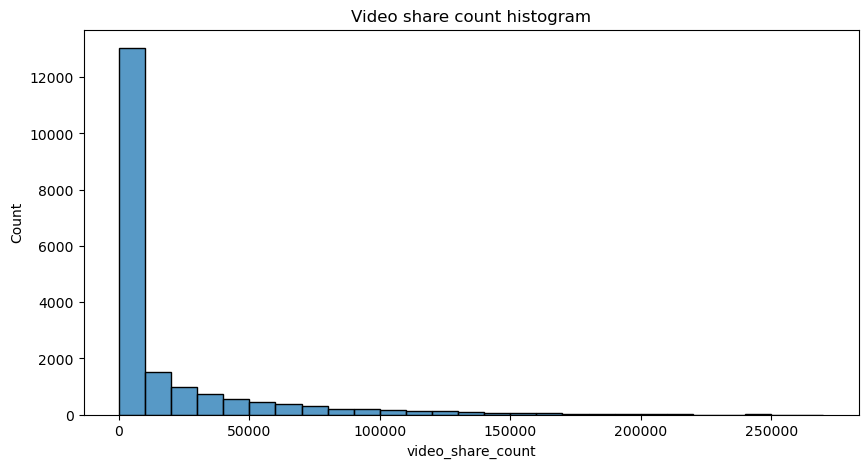

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(data['video_share_count'], bins=range(0,(270001),10000))
plt.title('Video share count histogram');

**Note:** The overwhelming majority of videos had fewer than 10,000 shares. The distribution is very skewed to the right.

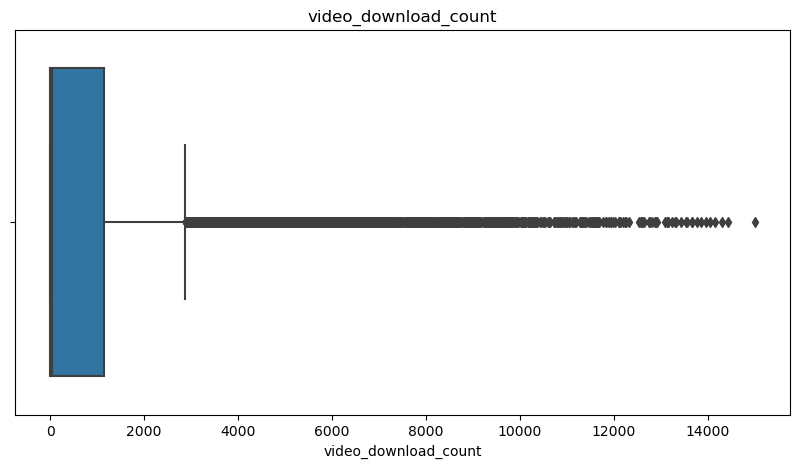

In [32]:
# a boxplot to visualize distribution of `video_download_count`
plt.figure(figsize=(10,5))
plt.title('video_download_count')
sns.boxplot(x=data['video_download_count']);

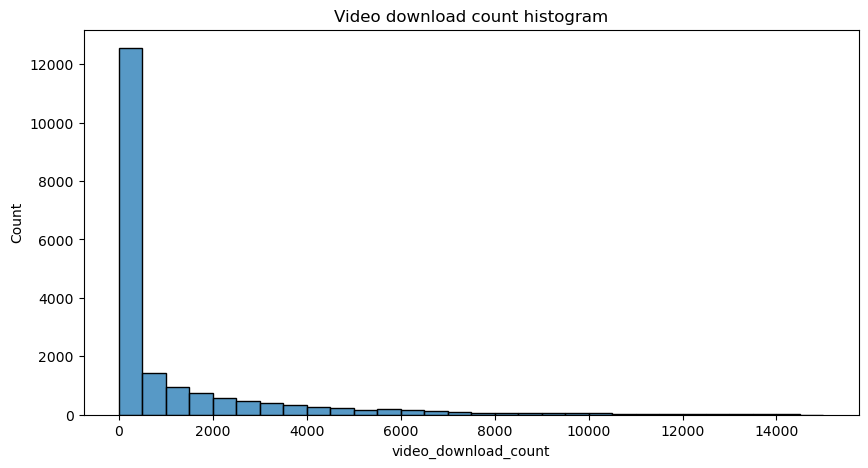

In [33]:
plt.figure(figsize=(10,5))
sns.histplot(data['video_download_count'], bins=range(0,(15001),500))
plt.title('Video download count histogram');

**Note:** The majority of videos were downloaded fewer than 500 times, but some were downloaded over 12,000 times. Again, the data is very skewed to the right.

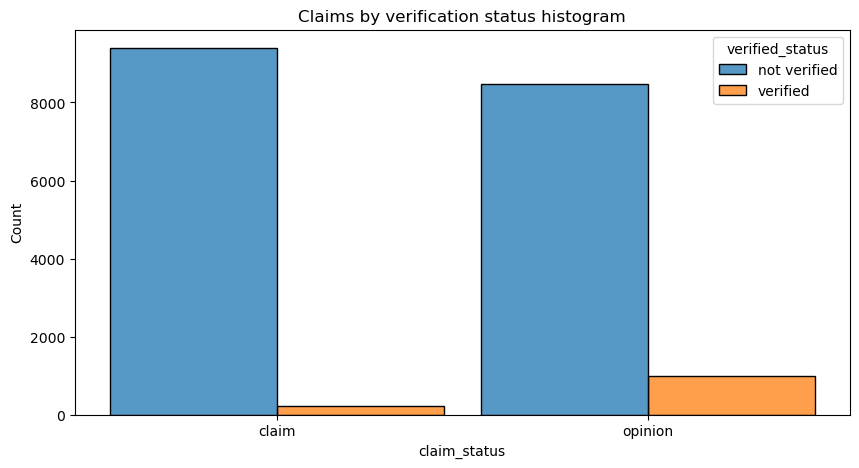

In [34]:
plt.figure(figsize=(10,5))
sns.histplot(data=data,
             x='claim_status',
             hue='verified_status',
             multiple='dodge',
             shrink=0.9)
plt.title('Claims by verification status histogram');

**Note:** There are far fewer verified users than unverified users, but if a user *is* verified, they are much more likely to post opinions.

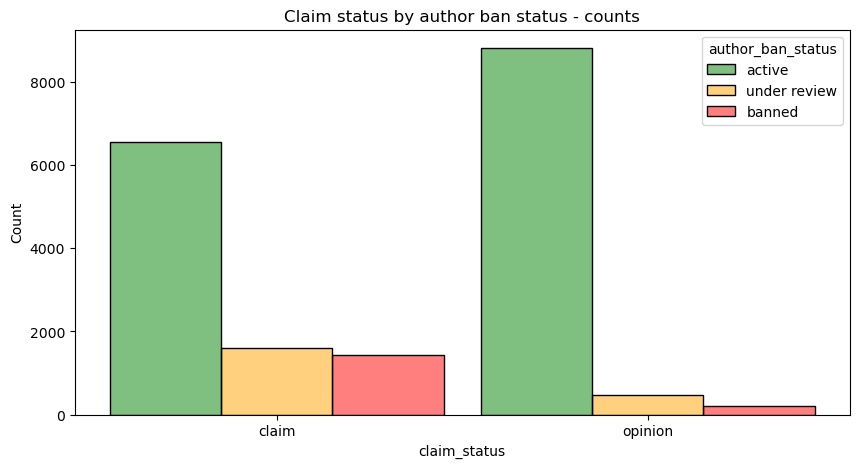

In [35]:
fig = plt.figure(figsize=(10,5))
sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');

**Note:** For both claims and opinions, there are many more active authors than banned authors or authors under review; however, the proportion of active authors is far greater for opinion videos than for claim videos. Again, it seems that authors who post claim videos are more likely to come under review and/or get banned.

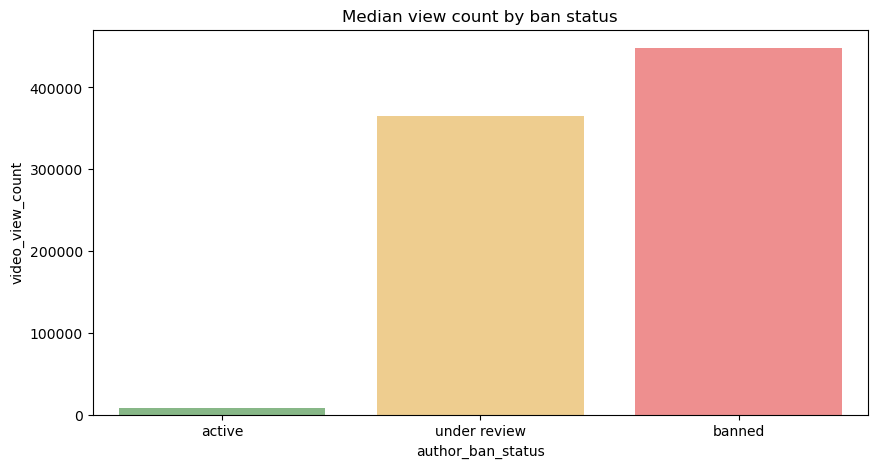

In [36]:
ban_status_counts = data.groupby(['author_ban_status']).median(
    numeric_only=True).reset_index()

fig = plt.figure(figsize=(10,5))
sns.barplot(data=ban_status_counts,
            x='author_ban_status',
            y='video_view_count',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)
plt.title('Median view count by ban status');

**Note:** The median view counts for non-active authors are many times greater than the median view count for active authors. Since you know that non-active authors are more likely to post claims, and that videos by non-active authors get far more views on aggregate than videos by active authors, then `video_view_count` might be a good indicator of claim status.

Indeed, a quick check of the median view count by claim status bears out this assessment:

In [37]:
data.groupby('claim_status')['video_view_count'].median()


claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

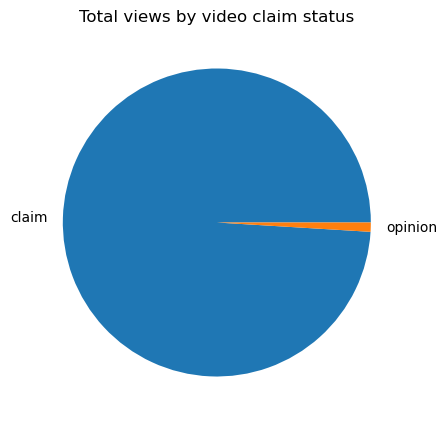

In [38]:
fig = plt.figure(figsize=(8,5))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

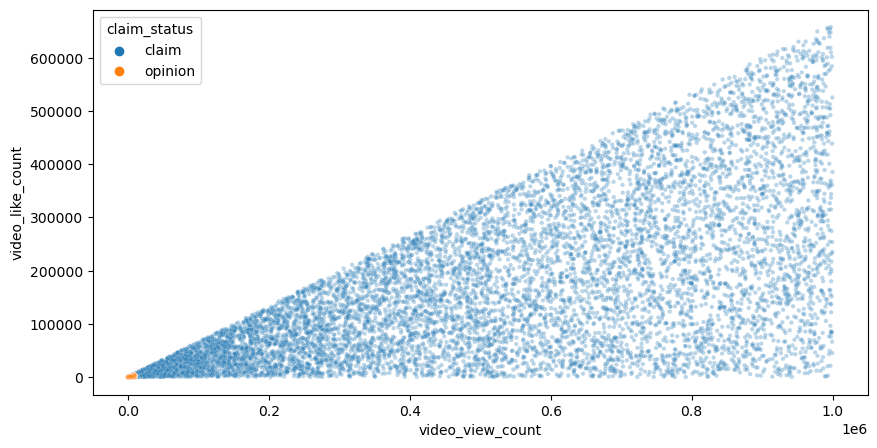

In [41]:
# a scatterplot of `video_view_count` versus `video_like_count` according to 'claim_status'
plt.figure(figsize=(10,5))
sns.scatterplot(x=data["video_view_count"], y=data["video_like_count"],
                hue=data["claim_status"], s=10, alpha=.3)
plt.show()

## Hypothesis Testing

**The goal** of this section is to apply descriptive and inferential statistics, probability distributions, and hypothesis testing in Python.
<br/>


In [4]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [5]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [6]:
# Display first few rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [8]:
# Computing the mean `video_view_count` for each group in `verified_status`
data.groupby("verified_status")["video_view_count"].mean()

verified_status
not verified    265663.785339
verified         91439.164167
Name: video_view_count, dtype: float64

**Note:**

*   **Null hypothesis**: There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).
*    **Alternative hypothesis**: There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).


In [9]:
# Conducting a two-sample t-test to compare means

# Save each sample in a variable
not_verified = data[data["verified_status"] == "not verified"]["video_view_count"]
verified = data[data["verified_status"] == "verified"]["video_view_count"]

# Implement a t-test using the two samples
stats.ttest_ind(a=not_verified, b=verified, equal_var=False)

Ttest_indResult(statistic=25.499441780633777, pvalue=2.6088823687177823e-120)

**Note:**

Since the p-value is extremely small (much smaller than the significance level of 5%), you reject the null hypothesis. You conclude that there **is** a statistically significant difference in the mean video view count between verified and unverified accounts on TikTok.


# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model 
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


## Regression Modelling

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
# Droping rows with missing values
data = data.dropna(axis=0)

In [10]:
# Displaying first few rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [11]:
# Checking for duplicates
data.duplicated().sum()

0

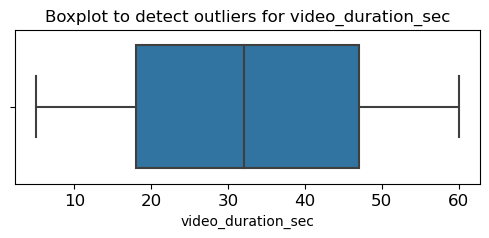

In [12]:
# Creating a boxplot to visualize distribution of `video_duration_sec`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_duration_sec', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_duration_sec'])
plt.show()

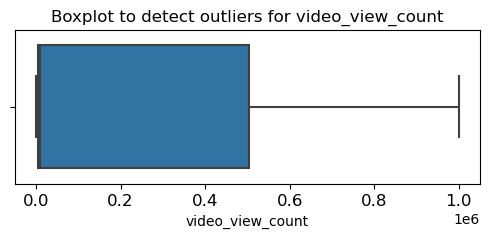

In [13]:
# Creating a boxplot to visualize distribution of `video_view_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_view_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_view_count'])
plt.show()

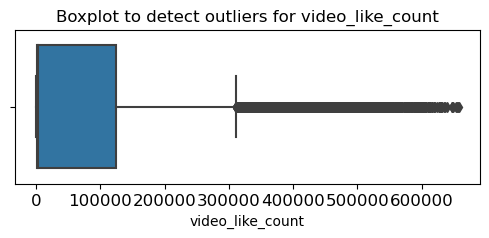

In [14]:
# Creating a boxplot to visualize distribution of `video_like_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_like_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_like_count'])
plt.show()

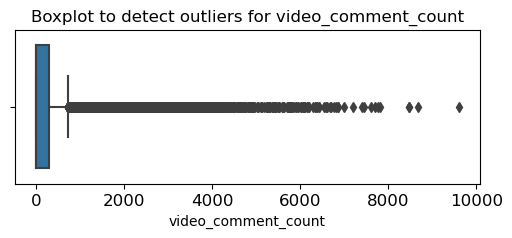

In [15]:
# Creating a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_comment_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=data['video_comment_count'])
plt.show()

In [16]:
# Checking for and handle outliers

percentile25 = data["video_like_count"].quantile(0.25)
percentile75 = data["video_like_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_like_count"] > upper_limit, "video_like_count"] = upper_limit

In [17]:
# Checking for and handle outliers

percentile25 = data["video_comment_count"].quantile(0.25)
percentile75 = data["video_comment_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

In [18]:
# Checking class balance
data["verified_status"].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

Approximately 94.2% of the dataset represents videos posted by unverified accounts and 5.8% represents videos posted by verified accounts. So the outcome variable is not very balanced.

In [19]:
# Identifying data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsampling the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combining majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Displaying new class counts
data_upsampled["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

In [20]:
# Geting the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [21]:
# Extracting the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

In [22]:
# Displaying first few rows of dataframe after adding new column
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


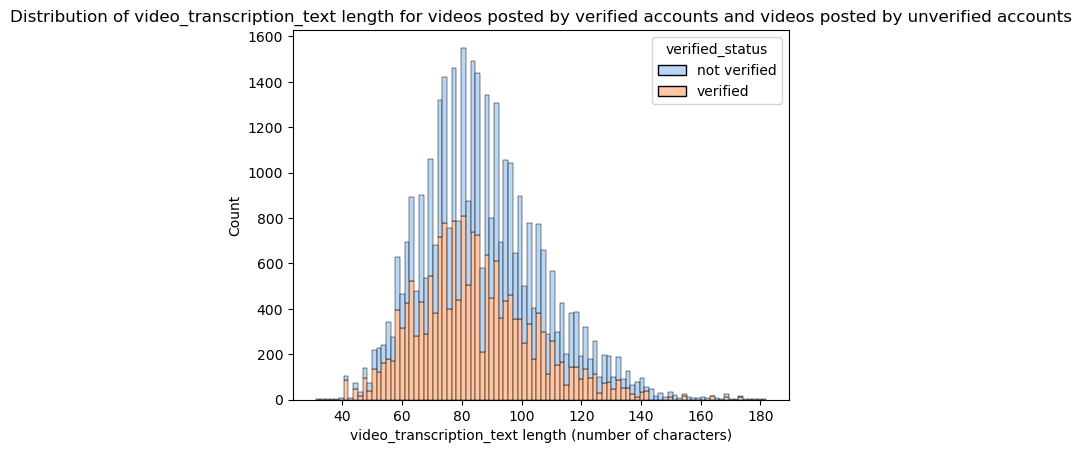

In [23]:
# Visualizing the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

In [24]:
# Coding a correlation matrix to help determine most correlated variables
data_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.217661
text_length,-0.193677,-0.007083,-0.002981,0.244693,0.216693,0.171651,0.173396,0.217661,1.000000


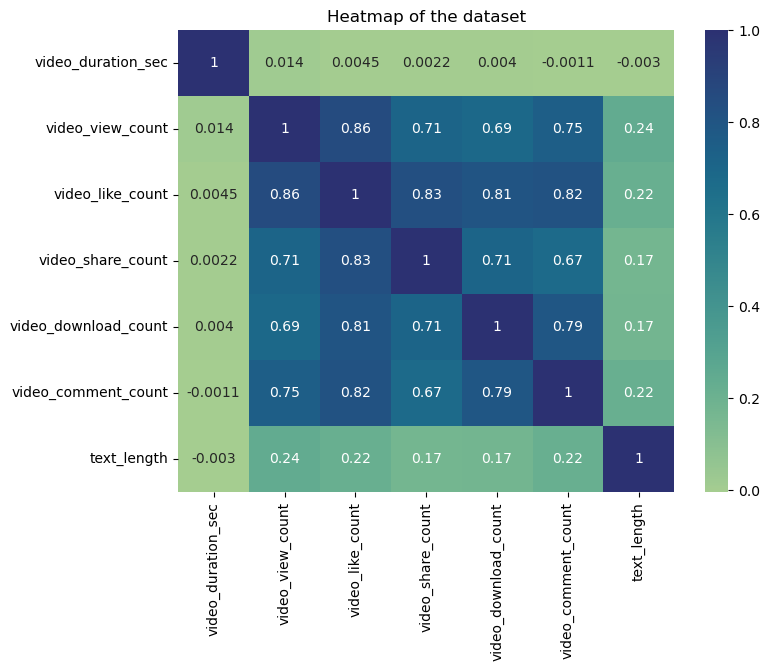

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

In [26]:
# Selecting outcome variable
y = data_upsampled["verified_status"]

In [27]:
# Selecting features
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

# Display first few rows of features dataframe
X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


In [28]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [29]:
# Geting shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

In [30]:
# Checking data types
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [31]:
# Geting unique values in `claim_status`
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [32]:
# Geting unique values in `author_ban_status`
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

In [33]:
# Selecting the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]

# Displaying first few rows
X_train_to_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [34]:
# Seting up an encoder for one-hot encoding the categorical features
X_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [35]:
# Fiting and transform the training features using the encoder
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [36]:
# Geting feature names from encoder
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [37]:
# Displaying first few rows of encoded training features
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [38]:
# Placing encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# Displaying first few rows
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [39]:
# Displaying first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_train.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,2252.0,23.0,4.0,0.0
20491,52,6664.0,550.0,53.0,2.0
25583,37,6327.0,257.0,3.0,0.0
18474,57,1702.0,28.0,0.0,0.0
27312,21,3842.0,101.0,1.0,0.0


In [40]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `claim_status` and `author_ban_status`,
# so that the indices align with those in `X_train_encoded_df` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_train_encoded_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


In [41]:
# Seting up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [42]:
# Encoding the training outcome variable
# Notes:
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Displaying the encoded training outcome variable
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

### Model Building

In [43]:
# Constructing a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)

In [44]:
# Selecting the testing features that needs to be encoded
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]

# Displaying first few rows
X_test_to_encode.head()

,claim_status,author_ban_status
21061,opinion,active
31748,opinion,active
20197,claim,active
5727,claim,active
11607,opinion,active


In [45]:
# Transforming the testing features using the encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)

# Displaying first few rows of encoded testing features
X_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [46]:
# Placing encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

# Displaying first few rows
X_test_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [47]:
# Displaying first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_test.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
21061,41,2118.0,57.0,5.0,2.0
31748,27,5701.0,157.0,1.0,0.0
20197,31,449767.0,75385.0,5956.0,728.5
5727,19,792813.0,56597.0,5146.0,728.5
11607,54,2044.0,68.0,19.0,2.0


In [48]:
# Concatenating `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)

# Displaying first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


In [49]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(X_test_final)

In [50]:
# Display the predictions on the encoded testing set
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

In [51]:
# Display the true labels of the testing set
y_test

21061        verified
31748        verified
20197        verified
5727     not verified
11607    not verified
             ...     
14756    not verified
26564        verified
14800    not verified
35705        verified
31060        verified
Name: verified_status, Length: 8942, dtype: object

In [52]:
# Encode the testing outcome variable
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

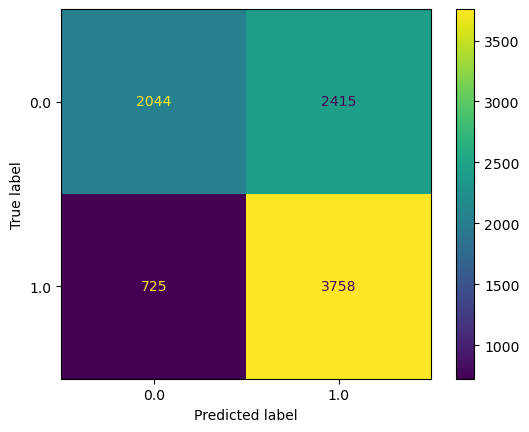

In [53]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives: the number of videos posted by unverified accounts that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of videos posted by unverified accounts that the model misclassified as posted by verified accounts.

The lower-left quadrant displays the number of false negatives: the number of videos posted by verified accounts that the model misclassified as posted by unverified accounts.

The lower-right quadrant displays the number of true positives: the number of videos posted by verified accounts that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [54]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.46      0.57      4459
not verified       0.61      0.84      0.71      4483

    accuracy                           0.65      8942
   macro avg       0.67      0.65      0.64      8942
weighted avg       0.67      0.65      0.64      8942



The classification report above shows that the logistic regression model achieved a precision of 61% and a recall of 84%, and it achieved an accuracy of 65%. Note that the precision and recall scores are taken from the "not verified" row of the output because that is the target class that we are most interested in predicting. The "verified" class has its own precision/recall metrics, and the weighted average represents the combined metrics for both classes of the target variable.

## Random Forest and XGBoost Modelling

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)


In [21]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [23]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [24]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [25]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [26]:
data.duplicated().sum()# Check for duplicates

0

In [27]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

In [28]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [29]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


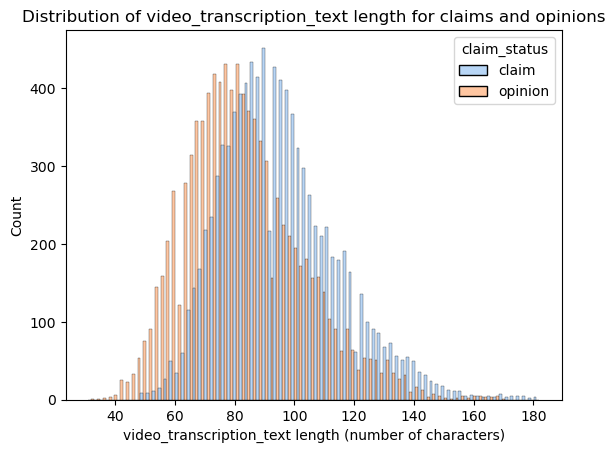

In [30]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

In [31]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


Assigning target variable.

In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [32]:
# Isolate target variable
y = X['claim_status']

In [33]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [34]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [36]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

**Observation:**
- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

In [39]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [40]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [44]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [45]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)

X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [46]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [48]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 7min 45s
Wall time: 7min 54s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'accuracy', 'f1', 'precision', 'recall'})

In [49]:
# Examine best recall score
rf_cv.best_score_

0.9948228253467271

In [50]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

**Observation:**

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

In [51]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [52]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 4min 34s
Wall time: 1min 28s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'accuracy', 'f1', 'precision', 'recall'})

In [53]:
xgb_cv.best_score_

0.9898176171763818

In [54]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

**Observation:**

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders


### **Evaluate models**

Evaluate models against validation data.


#### **Random forest**

In [55]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [56]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [57]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

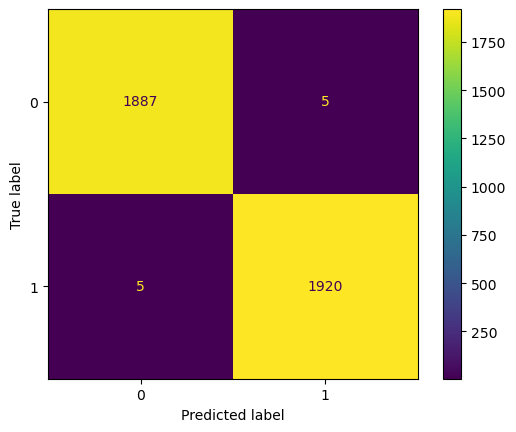

In [58]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

**Observation:**

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.


In [60]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Note:**

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

In [61]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [62]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

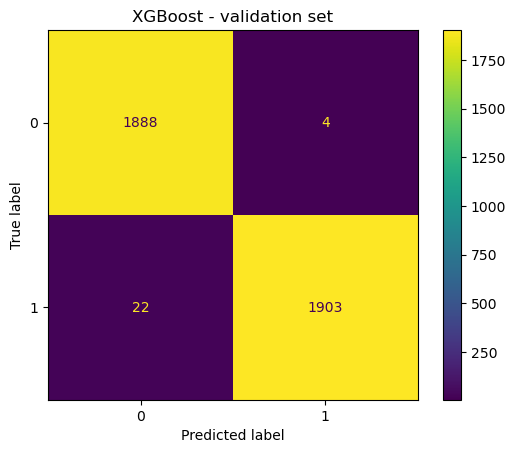

In [63]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [64]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Note:**

The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.


In [65]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

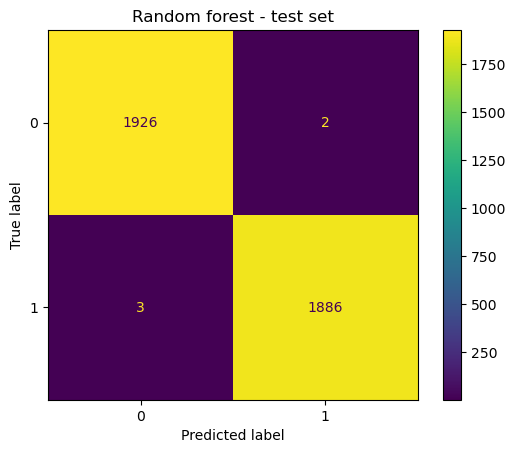

In [66]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

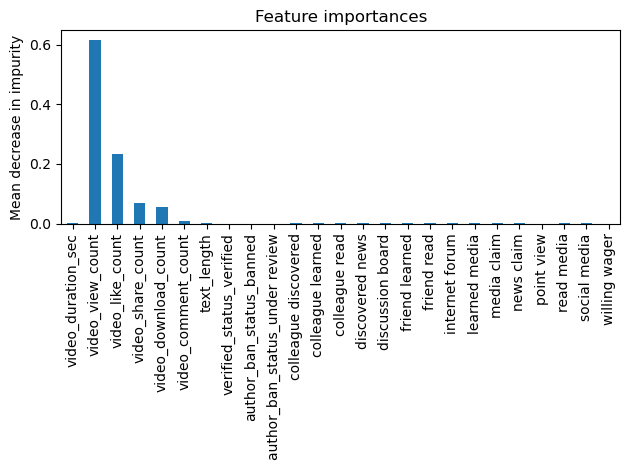

In [68]:
# Feature importances of champion model

importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Observation:**

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

**Conclusion:**

​
1.
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2.
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3.
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4.
The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.
